# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3-jitter1v2:oracle.run1.framed -> cores",
    "device": "cuda",
    "lr": 0.0001,
    "x_shape": [2, 256],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [
                "unit_mag",
                "jitter_256_1",
                "lowpass_+/-10MHz",
                "take_200",
            ],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [
                "unit_mag",
                "jitter_256_1",
                "take_200",
                "resample_20Msps_to_25Msps",
            ],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 1337,
    "dataset_seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_32', 'O_8', 'O_26', 'O_50', 'O_14', 'O_38', 'O_44', 'O_20'}


{'C_5', 'C_2', 'C_1', 'C_3', 'C_4'}


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 34.1351, train_label_loss: 2.8368, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 1690.2808, train_label_loss: 1.3130, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2169.6851, train_label_loss: 0.9790, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 1845.9900, train_label_loss: 0.6974, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 1836.8205, train_label_loss: 1.1303, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 1936.4565, train_label_loss: 1.1516, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 1757.1505, train_label_loss: 1.0191, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 1660.9451, train_label_loss: 0.6827, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 1790.6935, train_label_loss: 0.8487, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 1874.0931, train_label_loss: 1.0879, 


epoch: 1, source_val_acc_label: 0.5625, target_val_acc_label: 0.4146, source_val_label_loss: 62.6357, target_val_label_loss: 868.7131, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 1.4703, train_label_loss: 94.0742, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 1699.8957, train_label_loss: 0.7969, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2220.6226, train_label_loss: 0.8470, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 1836.6830, train_label_loss: 1.2913, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 1781.6736, train_label_loss: 1.1230, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 1947.5807, train_label_loss: 1.6767, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 1788.0219, train_label_loss: 0.9124, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 1680.1020, train_label_loss: 1.1792, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 1790.7099, train_label_loss: 1.2330, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2418.3458, train_label_loss: 0.7138, 


epoch: 2, source_val_acc_label: 0.6568, target_val_acc_label: 0.5923, source_val_label_loss: 0.9388, target_val_label_loss: 71.3041, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 3.0461, train_label_loss: 1.1498, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3843.0862, train_label_loss: 0.4965, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 4247.7099, train_label_loss: 0.8174, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 4608.5764, train_label_loss: 0.6179, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 4468.5777, train_label_loss: 0.7034, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3872.6299, train_label_loss: 1.2301, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 4050.9577, train_label_loss: 1.1510, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 4038.0887, train_label_loss: 0.5575, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2954.3801, train_label_loss: 0.8471, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 1683.5343, train_label_loss: 0.6867, 


epoch: 3, source_val_acc_label: 0.6829, target_val_acc_label: 0.6333, source_val_label_loss: 0.8590, target_val_label_loss: 113.7628, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 1.5328, train_label_loss: 0.8550, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 1746.0400, train_label_loss: 0.5022, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2118.4916, train_label_loss: 1.2393, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 1853.9168, train_label_loss: 0.8592, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 1837.5630, train_label_loss: 0.6807, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2285.7186, train_label_loss: 0.4497, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 1854.8326, train_label_loss: 1.2500, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 1825.1883, train_label_loss: 0.8260, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2248.2523, train_label_loss: 0.8691, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 1840.8756, train_label_loss: 0.5627, 


epoch: 4, source_val_acc_label: 0.7288, target_val_acc_label: 0.6315, source_val_label_loss: 0.7294, target_val_label_loss: 132.8474, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 1.6301, train_label_loss: 0.4122, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 1991.6620, train_label_loss: 0.5174, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2684.7285, train_label_loss: 0.7023, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2194.4409, train_label_loss: 1.0362, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2180.9205, train_label_loss: 0.6534, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2607.7512, train_label_loss: 0.4762, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2316.9281, train_label_loss: 0.5402, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2207.1337, train_label_loss: 0.3653, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2137.1944, train_label_loss: 0.8818, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2283.6331, train_label_loss: 0.4025, 


epoch: 5, source_val_acc_label: 0.7838, target_val_acc_label: 0.6321, source_val_label_loss: 0.5884, target_val_label_loss: 135.6937, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 1.4703, train_label_loss: 0.3975, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 1672.5009, train_label_loss: 0.9399, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 1874.8694, train_label_loss: 0.9036, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 1796.7909, train_label_loss: 0.4386, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 1670.2161, train_label_loss: 0.2529, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 1765.2390, train_label_loss: 0.3770, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2002.4477, train_label_loss: 0.6216, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 1809.7856, train_label_loss: 0.6608, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 1843.7741, train_label_loss: 0.4185, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2280.2002, train_label_loss: 0.2910, 


epoch: 6, source_val_acc_label: 0.8000, target_val_acc_label: 0.6261, source_val_label_loss: 0.5444, target_val_label_loss: 197.7093, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 1.4860, train_label_loss: 0.2494, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 1685.6419, train_label_loss: 0.9154, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 1847.9702, train_label_loss: 0.3674, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 1873.5978, train_label_loss: 0.6923, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 1672.1575, train_label_loss: 0.5189, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 1714.4655, train_label_loss: 1.0386, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2008.2703, train_label_loss: 0.2886, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 1803.8479, train_label_loss: 0.6236, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 1819.2709, train_label_loss: 0.3270, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2272.5491, train_label_loss: 0.3541, 


epoch: 7, source_val_acc_label: 0.8085, target_val_acc_label: 0.6894, source_val_label_loss: 0.5195, target_val_label_loss: 119.1173, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 1.6000, train_label_loss: 0.7037, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2898.1105, train_label_loss: 0.7954, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3420.2874, train_label_loss: 0.6529, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 4078.6544, train_label_loss: 0.3122, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3875.8687, train_label_loss: 0.3472, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3785.5316, train_label_loss: 0.6225, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3779.6393, train_label_loss: 0.6270, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 4368.1658, train_label_loss: 0.4474, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 4523.5560, train_label_loss: 0.7986, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2380.3231, train_label_loss: 0.5057, 


epoch: 8, source_val_acc_label: 0.8160, target_val_acc_label: 0.6631, source_val_label_loss: 0.4997, target_val_label_loss: 181.9880, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 1.5371, train_label_loss: 0.1866, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 1806.2629, train_label_loss: 0.7017, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 1751.0869, train_label_loss: 0.6095, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 1831.2397, train_label_loss: 0.4871, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 1738.0931, train_label_loss: 0.2963, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 1815.8547, train_label_loss: 0.9977, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 1827.4395, train_label_loss: 0.7706, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 1919.5866, train_label_loss: 0.4117, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 1973.6854, train_label_loss: 0.3355, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 1870.8588, train_label_loss: 0.3960, 


epoch: 9, source_val_acc_label: 0.8197, target_val_acc_label: 0.6577, source_val_label_loss: 0.4875, target_val_label_loss: 224.0339, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 1.5083, train_label_loss: 0.4885, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 1794.8023, train_label_loss: 0.4242, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3229.9476, train_label_loss: 0.7116, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 4038.3407, train_label_loss: 0.0501, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3900.2017, train_label_loss: 0.4438, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 1909.1077, train_label_loss: 0.2723, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 1848.9889, train_label_loss: 0.4717, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 1970.3917, train_label_loss: 0.9486, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 1954.3569, train_label_loss: 0.7449, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 1856.5101, train_label_loss: 0.1585, 


epoch: 10, source_val_acc_label: 0.8397, target_val_acc_label: 0.6403, source_val_label_loss: 0.4407, target_val_label_loss: 285.5051, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 1.5184, train_label_loss: 0.5030, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 1790.2762, train_label_loss: 0.5319, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3181.6632, train_label_loss: 0.6385, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3888.3188, train_label_loss: 0.1907, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3930.1763, train_label_loss: 0.5460, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 1867.2533, train_label_loss: 0.4481, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 1855.3501, train_label_loss: 0.2497, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 1927.5330, train_label_loss: 0.3212, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 1961.7142, train_label_loss: 0.2819, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 1858.8924, train_label_loss: 0.3149, 


epoch: 11, source_val_acc_label: 0.8155, target_val_acc_label: 0.6165, source_val_label_loss: 0.4975, target_val_label_loss: 333.3593, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

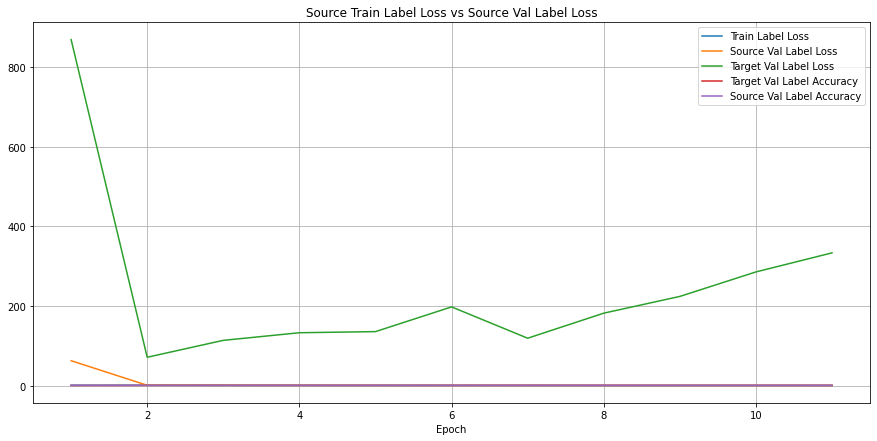

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

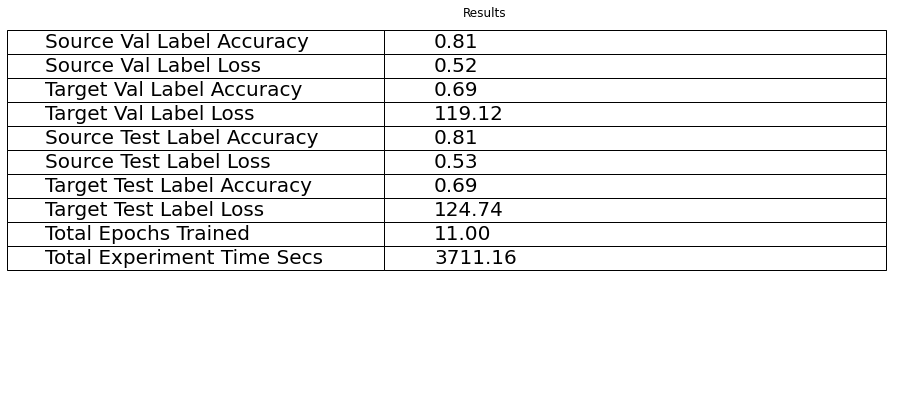

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

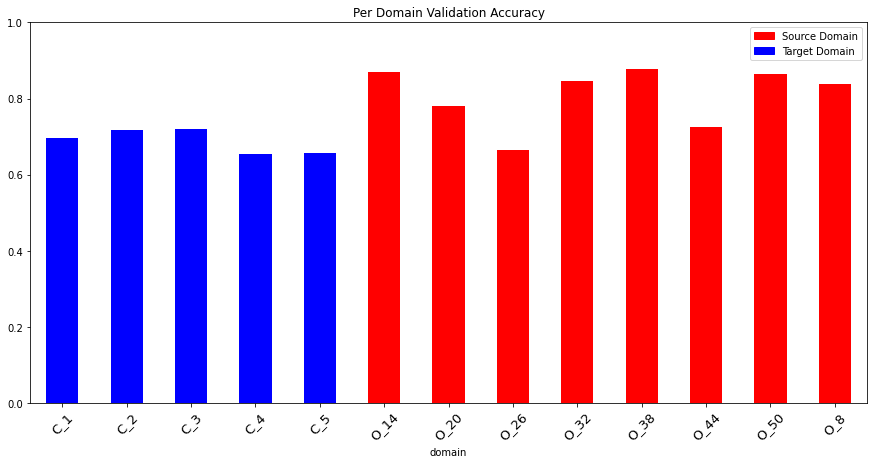

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8078125 Target Test Label Accuracy: 0.6860970819304153
Source Val Label Accuracy: 0.80849609375 Target Val Label Accuracy: 0.6894263698630136


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3-jitter1v2:oracle.run1.framed -> cores", "parameters": {"experiment_name": "tl_3-jitter1v2:oracle.run1.framed -> cores", "device": "cuda", "lr": 0.0001, "x_shape": [2, 256], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"i